# Time Series Analysis & Modeling
data used: [Chinese Monthly temperature data (1833-2013)](http://berkeleyearth.lbl.gov/auto/Regional/TAVG/Text/china-TAVG-Trend.txt)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import seaborn as sns
import warnings

## Table of Contents
* ** Helpful links and my motivation**  
* ** Why time series analysis**  
* ** What kind of data is suitable for time series analysis **  
* ** Math & Example**  
    * **AR(p) and MA(q)**
    * **ARMA(p,q)**
    * **ARIMA(p,d,q) and SARIMA(p,d,q)X(P,D,Q)_s**

## Helpful Link & my motivation

If you already knew time series and want to learn how to apply those techniques in python, here is couple links that help me get started. 
* [youtube video on ARIMA](https://www.youtube.com/watch?v=tJ-O3hk1vRw)
* [A complete guide to time series analysis in python](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)
* [A complete guide to time series analysis in python 1(nicer formatting)](https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3)
* [A complete guide to time series analysis in python 2(nicer formatting)](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/)
* [The most complete guid to time series analysis](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016)

Those blogs already did great jobs on presenting complete analysis on complicate time series. The main reason I started thinking about writing a blog about time series is that recently I had a EPIC FAIL during one of technical interviews.

<img src="https://media.giphy.com/media/KGTTNpVuGVhN6/giphy.gif">

Well, a woman is at her wisest when she knows she knew nothing. So it is time to pick it up time series again. A common assumption made by all the blogs above is that reader has some advanced understanding about the subject of interest - hypothesis testing and time series analysis. For my blog, I want to make it simple and step-by-step so that reader who are not familiar with this matter can follow as well. 

## Why do we use time series analysis?

The most important characteristic of time series analysis, in my opinion, is the order of the data. Order matters. If a series of temporal data is given - *1,2,3*, I will ask the question what is the relationship between 1 at $t_0$ and 3 at $t_h$, where h can be 0,1,...n.

Through exploring the temporal relationship among data, we turn a dimensionless problem to a dimentional problem. How? 

* Assume data 1,2,3 didn't happen in a time order. How do we estimate the next most likely happened number? Mean, median, mode, and probably construct probability distribution. But we can't run a regression method (require at least 1 dimension feature space).  
* However, if the data is temporal and they are collected at $t_0$, $t_1$,... and $t_n$. We can make hypothesis about value at $t_i$ is linearly correlated with value at $t_{i-2}$. Putting that hypothesis down as math equation, it would be $$x_t =\epsilon_t +\alpha*x_{t-2}$$ and now the problem turns into a 1-d regression problem
* If you agree with the logic above - the problem is a 1d problem, can you picture it being a p-dimention problem ($p<n$)? $$x_t = \epsilon_t+\sum^p_1{\alpha_i*x_{t-i}}$$ This is a type of time series model called autoregressive model, **AR(p)**, and we will cover it later. 

The two euqations above share an important trait - **we are using data from the PAST to forecast/estimate the FUTURE.** 

From [this blog post](http://userwww.sfsu.edu/efc/classes/biol710/timeseries/timeseries1.htm), we see other goals we can achieve by analyzing time series
<img src="image/goal_ts.png" alt="Goal of TS analysis" style="width: 80%"/>


## What kind of data is suitable for time series analysis

We are trying to extract meaningful statistic out of temporal data. However, if a temporal data is completely random - no systematic pattern in relation to time, then we cannot find insight. 

### what kind of data do we use here

**The time series we are concerned will have patterns and noises.** We are going to damp the noises and recognize the patterns. The data we are concerned are all [stationary](https://en.wikipedia.org/wiki/Stationary_process) (weakly stationary).

*If you understand what stationary means, keep reading; otherwise, you can skip this!*
* The assumption behind stationary process is very strong: it requires identical joint probaility distributions when shifted in time. In practice, it's hard to meet such requirement.
* So someone invented the notion of weakly stationary: the time series $x_i, i =1,2,3,...t$ has to be
    * constant mean and variance (finite) across time 
    * constant autocorrvariance s.t. $cov(x_1,x_2) = cov(x_{1+h},x_{2+h})$  



## Math & Example 

### Autoregressive AR(p)  and moving average MA(q) 
* Autoregressive: involves regressing the variable on its own lagged (i.e., past) values.
    * p is the order of AR process
    * $$X_t = c+\epsilon_t+\sum^p_1{\alpha_iX_{t-i}}$$
* moving average: involves modeling the error term ($\epsilon_t$) as a linear combination of error terms occurring contemporaneously and at various times in the past. 
    * q is the order of MA process
    * $$X_t = \mu+\epsilon_t+\sum^q_1{\theta_i\epsilon_{t-i}}$$
    
Let's first generate the two processes, i.e. AR(1) and MA(1), and see if we can find some patterns in the time series plots.

In [10]:
n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

df = pd.DataFrame({'MA1':smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)},index = range(n))

# set the MA(p) alphas equal to 0
alphas = np.array([0.6])
betas = np.array([0.])
ar = np.r_[1, alphas]
ma = np.r_[1, -betas]

df['AR1'] =smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)

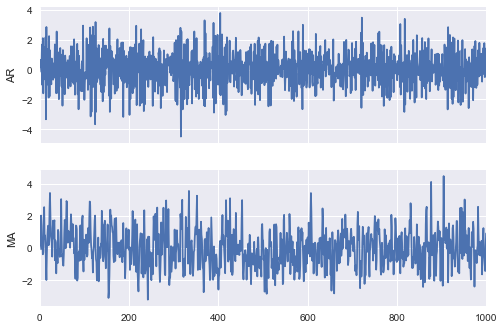

In [8]:
f, axarr = plt.subplots(2, sharex=True)
df['AR1'].plot(ax = axarr[0])
axarr[0].set_ylabel('AR')
df['MA1'].plot(ax = axarr[1])
axarr[1].set_ylabel('MA')

Both plots look so noisy and it's hard to tell what is going on. Here I am going to introduce two powerful plotting methods: acf and pacf. They will help us identify the order of AR and MA. 
* here is a detailed explaination on the two plots and what the difference are: [link_to_learn_about_pacf_acf](https://stats.stackexchange.com/questions/77248/what-is-autocorrelation-function)

In [11]:
from statsmodels.tsa.stattools import acf, pacf

# acf and pacf
def plot_acf_pacf(ts,lag):
    fig = plt.figure(figsize=(12,8))

    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(ts, lags=lag, ax=ax1)
    ax1.xaxis.set_ticks_position('bottom')
    ax1.axhline(y=0,linestyle='--',color='gray')
    ax1.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    ax1.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    fig.tight_layout();

    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(ts, lags=lag, ax=ax2)
    ax2.xaxis.set_ticks_position('bottom')
    ax2.axhline(y=0,linestyle='--',color='gray')
    ax2.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    ax2.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    fig.tight_layout();

In the **acf** plot, x axis represents time lag and y axis represent the correlation between points
separated by various time lags. At x=0, the correlation of $X_t$ is perfectly correlated with $X_t$, aka itself.
When lag = 1, the correlation of $X_t$ is 0.6 negatively correlated with $X_{t-1}$. The dash-horizontal line
represent the 95% signifcant interval. Any value that is above the dash line indicated that the correlation is
statsitcally significant (so we need to do something with it)

In the **pacf** plot, y-axis presents the correlation between points separated by various time lags after removing any other correlation effect from other points. 


AR1, we obseve the correlation tails off in acf plot and partial correlation at lag = 1 is significant in pacf plot.

NOTE: we often use pacf plot to identify the order p. If lag 1(except lag = 0) is significant, then we make the guess of p = 1. If both lag 1 and lag2 are significant in pacf, then we make the guess of p = 2.

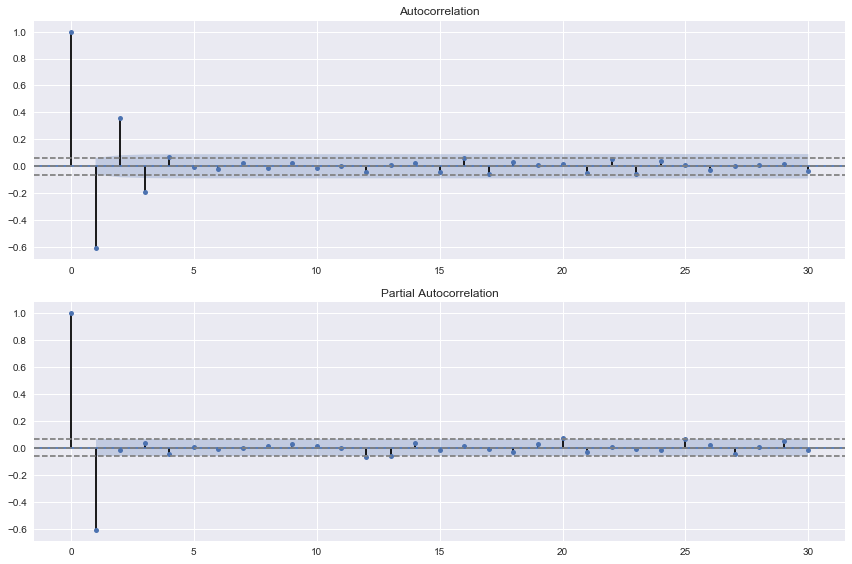

In [21]:
plot_acf_pacf(df.AR1,lag = 30)

MA1, we obseve the correlation is significant at lag 1 in acf plot and the partial correlation tails off.

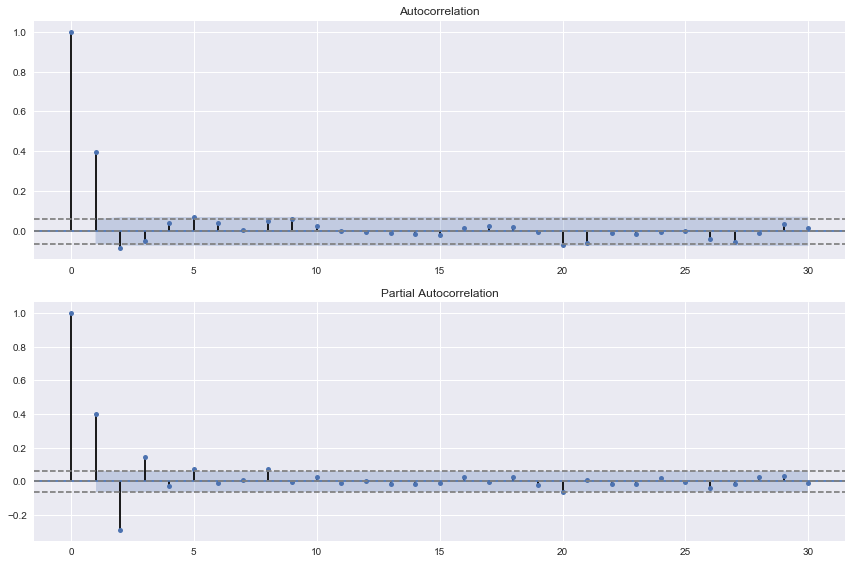

In [22]:
plot_acf_pacf(df.MA1,lag = 30)

**Q: how do we identify the order q for MA process?**   
**Q2: how do we identify the order p for AR process?**  

### ARMA(p,q) (autoregressive moving average model)

It is simply a merge of AR and MA. $$X_t = c+\epsilon_t+\sum^p_1{\alpha_iX_{t-i}}\mu+\sum^q_1{\theta_i\epsilon_{t-i}}$$

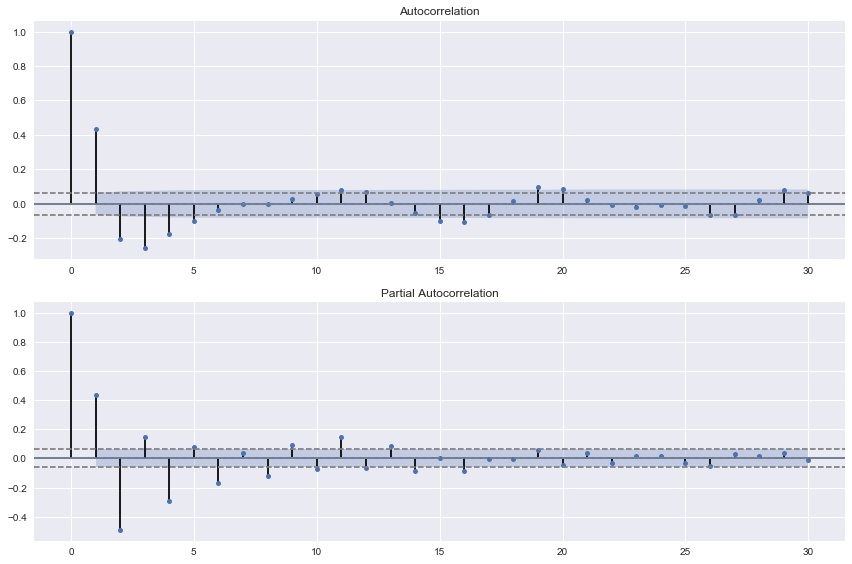

In [26]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(1000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.3])
betas = np.array([0.3, -0.8])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

df['arma22'] = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)

plot_acf_pacf(df.arma22,lag=30)

Looking at the two plots, you might get very confused: how are we going to determine the order for ARMA?   
**Pick a range (in this case, 0-4) that order q is most likely to be in from acf plot and pick a range (in this case, 0-6) that order p is most likely to be in from pacf plot. We then choose the best combination based on which model produces the lowest Akaike Information Criterion (AIC). After choosing the model, don't forget to check wether the coeficients for that model are significant. If not, go with the second best model and so forth**

In [27]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0, 6)
q = range(0, 5)

# Generate all different combinations of p, q and q triplets
pq = list(itertools.product(p, q))

print('Examples of parameter combinations for ARMA...')
print('ARMA: {} '.format(pq[1]))
print('ARMA: {}'.format(pq[2]))

Examples of parameter combinations for ARMA...
ARMA: (0, 1) 
ARMA: (0, 2)


In [31]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

for param in pq:
    try:
        mod = smt.ARMA(df.arma22,order=param)
        results = mod.fit(method='mle', trend='nc')
        if best_aic > results.aic:
            best_aic  = results.aic
            best_order = param
            best_mdl = mod
            print('ARMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue

ARMA(0, 1) - AIC:3031.24746247
ARMA(1, 3) - AIC:2971.2945981
ARMA(1, 4) - AIC:2968.38865554
ARMA(2, 2) - AIC:2967.24096222
ARMA(2, 3) - AIC:2966.51796012
ARMA(5, 4) - AIC:2963.26642394


Even though the ARMA(5,4) gives the lowest AIC, ARMA(2,2) has an AIC only 4 unit bigger.  

In [40]:
print 'if you look at the p-value for all the coefficients, you will see AR4, AR 5, and MA2 is not significant'
print 'You should test ARMA(2,3) yourself and see if all the coefficients are significant.'
results = best_mdl.fit(method='mle', trend='nc')
results.summary2()

if you look at the p-value for all the coefficients, you will see AR4, AR 5, and MA2 is not significant
You should test ARMA(2,3) yourself and see if all the coefficients are significant.


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: ARMA
====================================================================
Model:              ARMA             BIC:                 3012.3440 
Dependent Variable: arma22           Log-Likelihood:      -1471.6   
Date:               2017-07-19 17:03 Scale:               1.0000    
No. Observations:   1000             Method:              mle       
Df Model:           9                Sample:              01-01-1970
Df Residuals:       991                                   01-01-1970
Converged:          0.0000           S.D. of innovations: 1.053     
AIC:                2963.2664        HQIC:                2981.919  
---------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
---------------------------------------------------------------------
ar.L1.arma22      2.0216    0.1352  14.9552  0.0000   1.7567   2.2866
ar.L2.arma22     -1.9161    0.2432  -7.8772  0.0000  -2.3929  -1.4394
ar.L3.arma22      0.6795    0.1913   3.5518  0.0004   0.3045   1.0544
ar.L4.arma22     -0.0208    0.0910  -0.2282  0.8196  -0.1991   0.1576
ar.L5.arma22     -0.0952    0.0440  -2.1626  0.0308  -0.1815  -0.0089
ma.L1.arma22     -1.1288    0.1334  -8.4644  0.0000  -1.3902  -0.8675
ma.L2.arma22     -0.1181    0.1184  -0.9973  0.3189  -0.3502   0.1140
ma.L3.arma22      1.1435    0.0873  13.1043  0.0000   0.9724   1.3145
ma.L4.arma22     -0.5545    0.1276  -4.3452  0.0000  -0.8047  -0.3044
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            0.8023            -0.6687           1.0444            -0.1106
AR.2            0.8023             0.6687           1.0444             0.1106
AR.3            1.0134            -1.2140           1.5814            -0.1393
AR.4            1.0134             1.2140           1.5814             0.1393
AR.5           -3.8494            -0.0000           3.8494            -0.5000
MA.1           -1.0603            -0.0000           1.0603            -0.5000
MA.2            0.7785            -0.6931           1.0423            -0.1158
MA.3            0.7785             0.6931           1.0423             0.1158
MA.4            1.5654            -0.0000           1.5654            -0.0000
====================================================================

"""

In [39]:
print 'ARMA22 has coefficients that are significant.'
mod = smt.ARMA(df.arma22,order=(2,2))
results = mod.fit(method='mle', trend='nc')
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: ARMA
====================================================================
Model:              ARMA             BIC:                 2991.7797 
Dependent Variable: arma22           Log-Likelihood:      -1478.6   
Date:               2017-07-19 16:56 Scale:               1.0000    
No. Observations:   1000             Method:              mle       
Df Model:           4                Sample:              01-01-1970
Df Residuals:       996                                   01-01-1970
Converged:          1.0000           S.D. of innovations: 1.060     
AIC:                2967.2410        HQIC:                2976.567  
---------------------------------------------------------------------
                 Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
ar.L1.arma22     0.7525    0.0505   14.8975  0.0000   0.6535   0.8515
ar.L2.arma22    -0.1835    0.0350   -5.2499  0.0000  -0.2521  -0.1150
ma.L1.arma22     0.1510    0.0432    3.4929  0.0005   0.0663   0.2357
ma.L2.arma22    -0.7357    0.0422  -17.4534  0.0000  -0.8184  -0.6531
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            2.0499            -1.1164           2.3342            -0.0794
AR.2            2.0499             1.1164           2.3342             0.0794
MA.1           -1.0677             0.0000           1.0677             0.5000
MA.2            1.2730             0.0000           1.2730             0.0000
====================================================================

"""

I think now you have a better idea on how to choose the order q and p. Let me sum it up and we will move on to solve some real problems!
* Look at the spikes in acf, get a range of lags that includes the significant spikes -> determine q 
* Look at the spikes in pacf, get a range of lags that includes the significant spikes -> determine p
* We choose the best combination based on which model produces the lowest Akaike Information Criterion (AIC).
* Check wether the coeficients for that model are significant. If not, go with the second best model and so forth.

### ARIMA (p,d,q) and SARIMA (p,d,q) X (P,D,Q)_s

We talked about AR, MA, and ARMA models above and those modeling techniques are used to model stationary time series. However, we rarely see time series that are stationary in real life. Because life presents us difficult problems all the time, we have to tackle them by asking the right questions: 
* Is this time series stationary (or weakly stationary)? 
* Can I transform the time series to make it stationary (or weakly stationary)?

Well, first let's get some real life data


In [46]:
import pandas_datareader.data as web
import datetime

In [49]:
end = '2017-07-10'
start = '2007-01-01'
#INPX = data.DataReader('INPX', 'yahoo', start, end)
get_px = lambda x: web.DataReader(x, 'yahoo', start, end)['Adj Close']
symbols = ['SPY']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})

ConnectionError: HTTPConnectionPool(host='ichart.finance.yahoo.com', port=80): Max retries exceeded with url: /table.csv?a=0&ignore=.csv&s=SPY&b=1&e=10&d=6&g=d&f=2017&c=2007 (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x11a5fb290>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))